In [1]:
import sys
import random

sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


### 基本図を書くためのシミュレーションファイル

最終更新日: 2023/07/25

In [26]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 300
time_step = 0.5
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20 
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 50
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい
should_scatter=False

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, scatter=False):
    if scatter:
        x_coordinates = [random.uniform(0, total_distance) for _ in range(car_num)]

        return sorted(x_coordinates, reverse=True)[idx]
        
    delta = total_distance / car_num
    x_coordinates = [total_distance - delta * (idx+1) for idx in range(car_num)]
    return x_coordinates[idx]

result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")
increment = 5

最大ドローン台数：100台
この設定だと法定速度は時速108.0km
巡航距離は1.0kmです


In [27]:
# シミュレーション用の関数

def simulate_with_parameters(**kwagrs):
    helly_params = kwagrs.get("helly_params")
    simulation_list = []

    for i in range(int(drone_num_for_max_density / increment)):
        DRONE_NUM = (i+1) * increment
        if (DRONE_NUM >206):
            break
        cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i, should_scatter),
                        ycor=0, 
                        v_0=0,
                        legal_speed=legal_speed, 
                        scale_factor=scale_factor,
                        drone_idx = i,
                        helly_params=helly_params,
                        )
                  for i in range(DRONE_NUM)]
        print(DRONE_NUM)
        simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )
        simulation.run()
        simulation_list.append(simulation)
    
    return simulation_list


### ここからシミュレーション開始。

In [33]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor
rear_brake_acc = 0.4
front_brake_acc = 0.8


helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake":front_brake_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }
simulation_list_helly = simulate_with_parameters(helly_params = helly_params)
simulation_list_rss = simulate_with_parameters(helly_params = rss_params)

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実

### ここからは解析に入る

In [34]:
def analysis(**kwagrs):
    dataList = []
    simulation_list = kwagrs.get("simulation_list",[])
    isRss = kwagrs.get("isRss",False)
    model = "RSS" if isRss else "Helly"
    for simulation in simulation_list:
        cars = simulation.drone_list
        # 流量を計算する
        velocity_list = []

        # これは事故っている場合
        if int(simulation_steps * 0.95) > len(cars[0].v_xList):
            velocity_list.append(0)
        else:
            for car in cars:
                snap_frame = int(simulation_steps * 0.95)
                velocity_list.append(car.v_xList[snap_frame])
        mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

        # 密度：1km当たりの台数
        rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
        flow = rho * mean_velocity

        # プロット用に保存
        dataToSave = {
            "density":rho,
            "flow":flow,
            "mean_velocity":mean_velocity,
            "start_position":"unscattered",
            "drone_num":len(cars),
            "model":model
        }
        dataList.append(dataToSave)

    df = pd.DataFrame(dataList)
    return df


In [30]:
df_helly = analysis(simulation_list=simulation_list_helly)
print(df_helly)

    density        flow  mean_velocity start_position  drone_num  model
0       5.0  150.000000      30.000000    unscattered          5  Helly
1      10.0  300.000000      30.000000    unscattered         10  Helly
2      15.0  450.000000      30.000000    unscattered         15  Helly
3      20.0  600.000000      30.000000    unscattered         20  Helly
4      25.0  625.296879      25.011875    unscattered         25  Helly
5      30.0  583.798023      19.459934    unscattered         30  Helly
6      35.0  542.169394      15.490554    unscattered         35  Helly
7      40.0  500.677454      12.516936    unscattered         40  Helly
8      45.0  459.025242      10.200561    unscattered         45  Helly
9      50.0  417.488450       8.349769    unscattered         50  Helly
10     55.0  376.013315       6.836606    unscattered         55  Helly
11     60.0  334.283085       5.571385    unscattered         60  Helly
12     65.0  292.764880       4.504075    unscattered         65

### グラフのVisualization

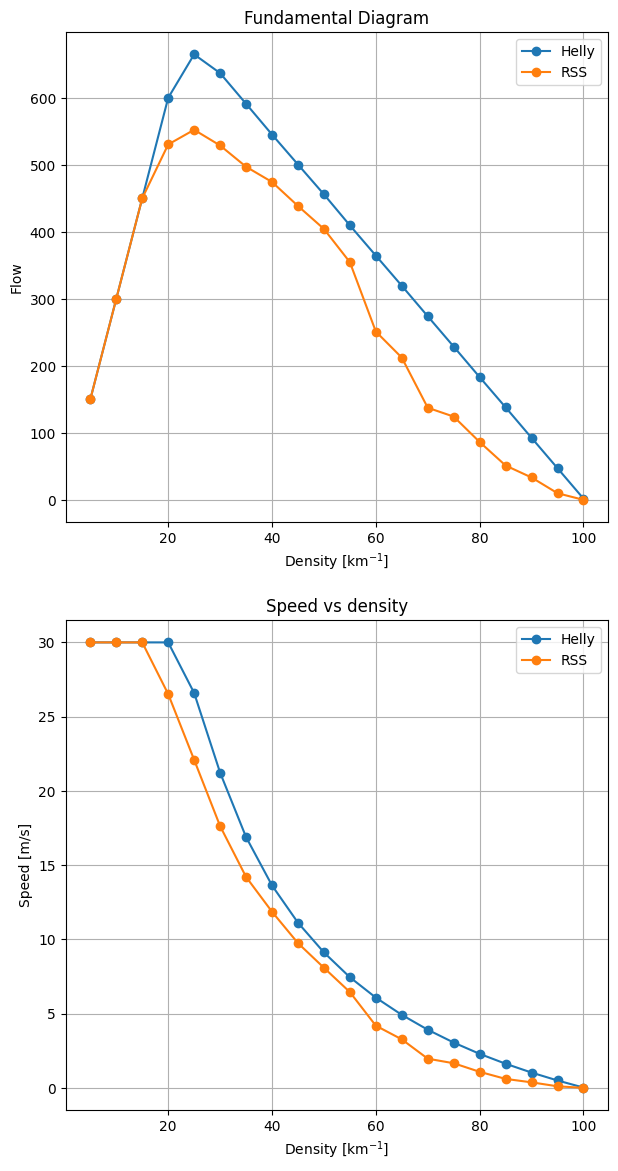

    density        flow  mean_velocity start_position  drone_num  model
0       5.0  150.000000      30.000000    unscattered          5  Helly
1      10.0  300.000000      30.000000    unscattered         10  Helly
2      15.0  450.000000      30.000000    unscattered         15  Helly
3      20.0  600.000000      30.000000    unscattered         20  Helly
4      25.0  664.878975      26.595159    unscattered         25  Helly
5      30.0  636.907262      21.230242    unscattered         30  Helly
6      35.0  591.171928      16.890627    unscattered         35  Helly
7      40.0  545.242782      13.631070    unscattered         40  Helly
8      45.0  500.523826      11.122752    unscattered         45  Helly
9      50.0  455.999438       9.119989    unscattered         50  Helly
10     55.0  409.648609       7.448157    unscattered         55  Helly
11     60.0  364.539865       6.075664    unscattered         60  Helly
12     65.0  319.534845       4.915921    unscattered         65

In [35]:
df_helly = analysis(simulation_list=simulation_list_helly)
df_rss = analysis(simulation_list=simulation_list_rss, isRss=True)

# 折れ線グラフを描画
plt.figure(figsize=(7, 14))
plt.subplot(2, 1, 1)
plt.plot(df_helly["density"], df_helly["flow"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["flow"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df_helly["density"], df_helly["mean_velocity"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["mean_velocity"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs density')
plt.grid(True)
plt.legend()
plt.savefig(f"FD_RSS_vs_Helly_scatter={should_scatter}")
plt.show()

print(df_helly.head(20))
print(df_rss.head(20))

In [21]:
# デバッグ用
DRONE_NUM = 40
response_time = 0.5
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_brake_acc = 0.8
rear_brake_acc = 0.4

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, scatter=False):
    if scatter:
        x_coordinates = [random.uniform(0, total_distance) for _ in range(car_num)]

        return sorted(x_coordinates, reverse=True)
        
    delta = total_distance / car_num
    x_coordinates = [total_distance - delta * (idx+1) for idx in range(car_num)]
    return x_coordinates

initial_xcors = scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, should_scatter)


In [22]:
min_acc = MIN_ACC_REAL_WORLD / scale_factor
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "front_car_brake": front_brake_acc,
    "rear_brake_acc":rear_brake_acc,
    "response_time":response_time, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1,
    "isRss":False,
  }

cars_list = [FlyingCars(xcor=initial_xcors[i],
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=rss_params,
                     )
               for i in range(DRONE_NUM)]
simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )

result = simulation.run()
print((simulation.drone_list[1].v_xList))
print(result)
# simulation.create_video("test_nonRSS.mp4")

===PARALLEL実行===
!!!!!!!!!!!!!
追い抜き発生
step=439_先行車(id=27)のx座標 27.227502965404 27.227502965404
follower(id=28)のx座標 27.209712436075307
delta_x 0.017790529328692628  v_x 0.04298152382742426  leader_v_x 0
接近距離 0.02149076191371213
!!!!!!!!!!!!!
[0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39382717266516987, 0.43203890587173394, 0.46581814083375894, 0.4960608246263752, 0.523422621223608, 0.5483664564089884, 0.5712074165743632, 0.592152803520978, 0.6113361643798956, 0.6288448879803846, 0.6447415151252347, 0.6590792831063743, 0.6719126481455765, 0.6833036356396687, 0.69332488663027, 0.7020602255719071, 0.709603490883422, 0.7160562634275452, 0.7215250125338251, 0.7261180644764745, 0.7299426913862772, 0.733102523800479, 0.7356954097706492, 0.7378117784126944, 0.7395335156004498, 0.7409333229929316, 0.7420745070801663, 0.74301113052586, 0.7437884518113032, 0.7444435791531645, 0.7450062691526668, 0.7454998081285755, 0.7459419233296216, 0.7463456812003153, 0.7467203398115848, 0.74707

['0.000', '0.050', '0.100', '0.150', '0.200', '0.250', '0.300', '0.350', '0.397', '0.439', '0.475', '0.508', '0.536', '0.562', '0.584', '0.604', '0.621', '0.636', '0.650', '0.662', '0.672', '0.681', '0.690', '0.697', '0.703', '0.709', '0.714', '0.718', '0.722', '0.725', '0.728', '0.731', '0.733', '0.735', '0.737', '0.739', '0.740', '0.742', '0.743', '0.744', '0.745', '0.745', '0.746', '0.747', '0.747', '0.748', '0.748', '0.748', '0.749', '0.749', '0.749', '0.749', '0.749', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.750', '0.749', '0.749', '0.749', '0.749', '0.748', '0.748', '0.748', '0.747', '0.747', '0.746', '0.746', '0.746', '0.745', '0.745', '0.744', '0.744', '0.744', '0.744', '0.743', '0.744', '0.744', '0.744', '0.744', '0.745', '0.746', '0.747', '0.748', '0.749', '0.751', '0.752', '0.754', '0.755', '0.757', '0.759', '0.761', '0.762', '0.764', '0.765', '0.766', '0.767', '0.768', '0.768', '0.769', '0.768', '0.768', '0.767', '0.766', 

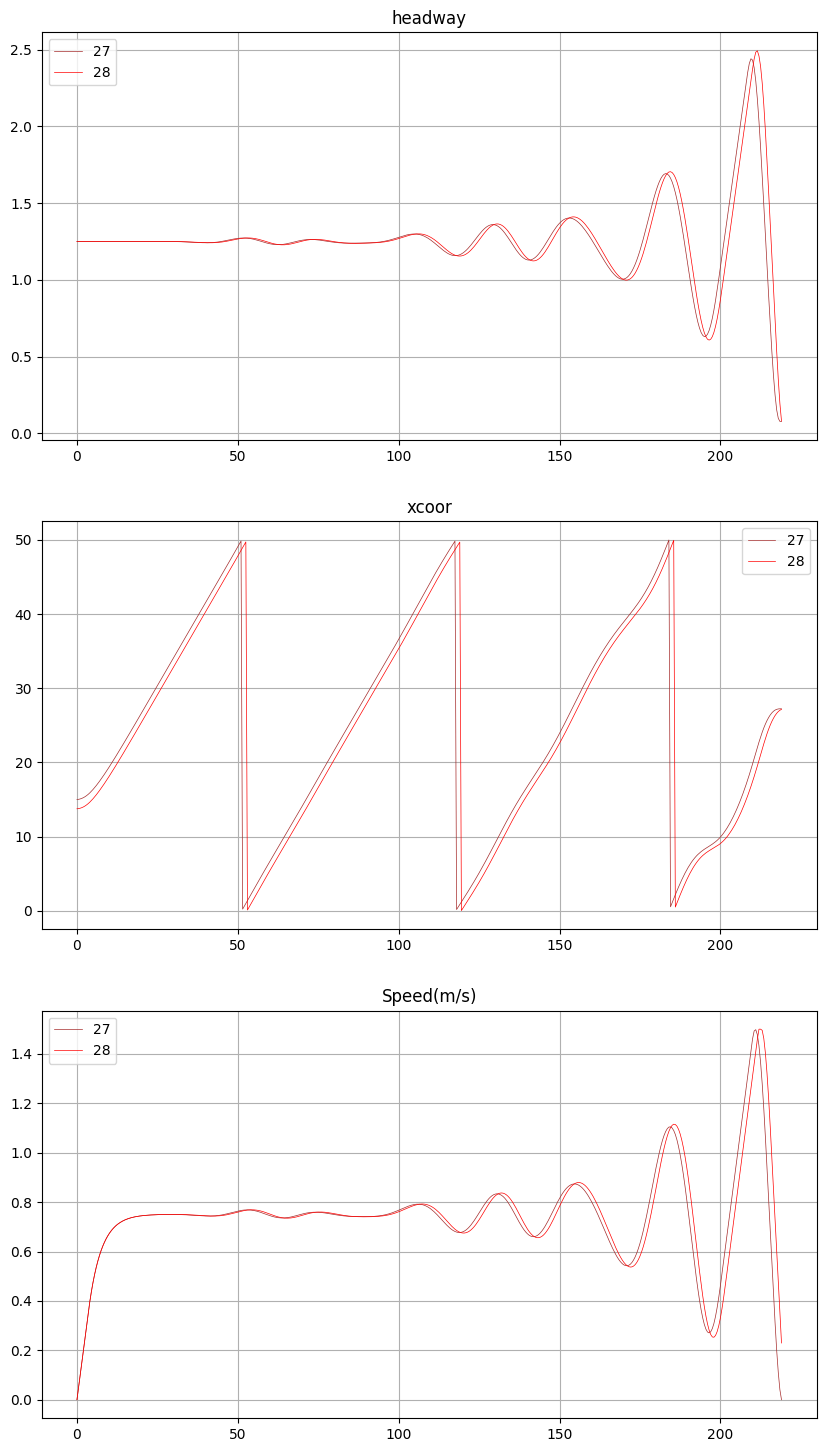

In [13]:
follower_idx = result["follower_idx"]
leader_idx = result["follower_idx"] -1
step = result["step"]
print(["{:.3f}".format(a) for a in simulation.drone_list[leader_idx].v_xList])
print(["{:.3f}".format(a) for a in simulation.drone_list[follower_idx].v_xList])
print("============")
print(["{:.3f}".format(a) for a in simulation.drone_list[leader_idx].headwayList])
print(["{:.3f}".format(a) for a in simulation.drone_list[follower_idx].headwayList])

print("============")
print(["{:.4g}".format(a) for a in simulation.drone_list[leader_idx].xcorList])
print(["{:.4g}".format(a) for a in simulation.drone_list[follower_idx].xcorList])
color_list = ["orange", "pink", "blue", "brown", "red", "green"]
drone_list = simulation.drone_list
print(min_acc)

plot_drone_list = [leader_idx,follower_idx]

t = np.arange(step) * time_step
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.headwayList[:step]), color=color_list[idx % 6 ], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('headway')


plt.subplot(3, 1, 2)
t = np.arange(step) * time_step
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.xcorList[:step]), color=color_list[idx % 6], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('xcoor')


plt.subplot(3, 1, 3)
t = np.arange(step) * time_step
for idx in plot_drone_list:
    drone = drone_list[idx]
    plt.plot(t, np.array(drone.v_xList[:step]), color=color_list[idx % 6], linewidth=0.5, label=idx)
plt.legend()
plt.grid(True)
plt.title('Speed(m/s)')


plt.show()



In [12]:
def calc_rss_distance(my_speed, rss_params, delta_x, proceeding_speed = 0):
    rho_delay = rss_params.get("response_time", 0.5)
    min_comfortable_accel = rss_params.get("rear_brake_acc", min_acc*0.5)
    front_car_brake = rss_params.get("front_car_brake", min_acc)
    d = rss_params.get("d")
    lambda_1 = rss_params.get("lambda_1")
    front_car_brake_distance = proceeding_speed**2 / front_car_brake / 2
    brake_distance = (my_speed + max_acc*rho_delay)**2/(min_comfortable_accel)/2
    idle_distance = my_speed * rho_delay + max_acc * rho_delay**2 / 2
    rss_distance = d + brake_distance + idle_distance - front_car_brake_distance
    print("my speed:", my_speed)
    print( max_acc, min_comfortable_accel, front_car_brake)
    print(min_comfortable_accel)
    print("proceeding_speed:", proceeding_speed)
    print("front_car_brake_distance:", front_car_brake_distance)
    print("brake_distance:", brake_distance)
    print("idle_distance:", idle_distance)
    print("RSS距離: ",d + brake_distance + idle_distance - front_car_brake_distance)
    print("生じさせるべき加速度:", lambda_1 * (delta_x -rss_distance))


def calc_rss_info(rss_params, delta_x, proceeding_speed = 0):
    d = rss_params.get("d")
    k1 = (1 / rear_brake_acc - 1 / front_brake_acc) * 1/2
    k2 = response_time * (1 + max_acc / rear_brake_acc )
    k3 = max_acc*response_time**2 / 2 * (1+max_acc / rear_brake_acc) + d - delta_x
    v = ((k2 ** 2 - 4*k1*k3)**(1/2) - k2 ) / 2 /k1
    print(k1, k2, k3)
    print("定常速度=",v)

    print("======")
    print(k1 * v**2 + k2*v + k3)

    print("============")
    rho_delay = rss_params.get("response_time", 0.5)
    min_comfortable_accel = rss_params.get("rear_brake_acc", min_acc*0.5)
    front_car_brake = rss_params.get("front_car_brake", min_acc)
    front_car_brake_distance = proceeding_speed**2 / front_car_brake / 2
    brake_distance = (v + max_acc*rho_delay)**2/(min_comfortable_accel)/2
    idle_distance = v * rho_delay + max_acc * rho_delay**2 / 2

    print("my speed:", v)
    print("a_max:", max_acc)
    print(min_comfortable_accel)
    print("proceeding_speed:", proceeding_speed)
    print("front_car_brake_distance:", front_car_brake_distance)
    print("brake_distance:", brake_distance)
    print("idle_distance:", idle_distance)
    print("RSS距離: ",d + brake_distance + idle_distance - front_car_brake_distance)

print(rss_params)
calc_rss_distance(0.75, rss_params, 1.8, 0)
print()
# calc_rss_info(rss_ params,1)

{'max_accel': 0.1, 'min_accel': 0.25, 'front_car_brake': 0.8, 'rear_brake_acc': 0.4, 'response_time': 0.5, 'lambda_1': 0.2, 'lambda_2': 0.4, 'd': 0.499, 'T_des': 1, 'isRss': True}
my speed: 0.75
0.1 0.4 0.8
0.4
proceeding_speed: 0
front_car_brake_distance: 0.0
brake_distance: 0.8000000000000002
idle_distance: 0.3875
RSS距離:  1.6865
生じさせるべき加速度: 0.022699999999999988



In [8]:
simulation.create_video("debug.mp4")

frame_0__Done
frame_100__Done
frame_200__Done
frame_300__Done
frame_400__Done
動画作成開始


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


END
